# Quantum Docking with Neutral Atoms

### Demo notebook

In [1]:
import sys

sys.path.append("./src")

In [2]:
%load_ext autoreload
%autoreload 2

from graph.mapping import embed_problem_to_QPU
from rdkit import Chem
from draw.features import draw_feature_list, draw_multiple_dockings
from draw.graph import draw_interaction_graph, draw_multiple_cliques
from graph.interaction_graph import (
    build_binding_interaction_graph,
    build_distance_matrix,
)
from mol_processing.features import name_features_by_count
from mol_processing.mol import get_features
from pulser.devices import Chadoq2
import rdkit
from solver.quantum import solver_VQAA, plot_distribution
from networkx.algorithms import approximation as approx
from graph.mapping import build_complementary_graph, embed_problem_to_QPU
import warnings

warnings.filterwarnings("ignore")


taplcq


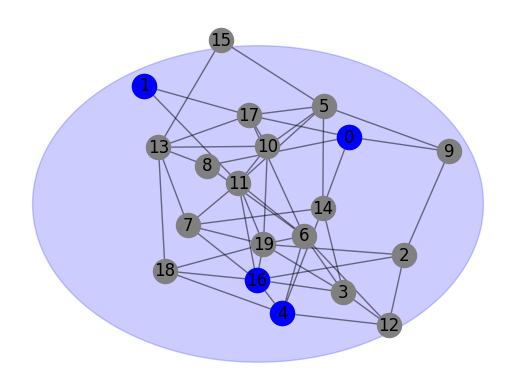

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


def draw_graph_with_clique_highlighted(n: int, p: float, clique_nodes: list[int]):
    """
    Draws a dense graph and highlights a clique within it by surrounding all the clique nodes with a blue,
    slightly transparent halo.

    Args:
        n (int): Number of nodes in the graph.
        p (float): Probability of edge creation (used in an Erdős-Rényi model).
        clique_nodes (list[int]): List of nodes forming the clique to be highlighted.
    """
    # Create a dense graph using the Erdős-Rényi model
    G = nx.erdos_renyi_graph(n, p)  

    # Determine positions of all nodes using spring layout
    pos = nx.spring_layout(G)

    # Draw all edges
    nx.draw_networkx_edges(G, pos, alpha=0.5)

    # Draw all nodes
    nx.draw_networkx_nodes(G, pos, node_color="grey", node_size=300)

    # Draw node labels
    nx.draw_networkx_labels(G, pos)

    # Extract positions of the clique nodes
    clique_pos = np.array([pos[node] for node in clique_nodes])

    # Calculate the centroid of the clique nodes
    centroid = clique_pos.mean(axis=0)

    # Calculate a suitable radius for the halo that englobes all clique nodes
    max_distance = np.linalg.norm(clique_pos - centroid, axis=1).max()
    halo_radius = max_distance + 0.1  # Add some padding

    # Draw a halo around the entire clique
    halo_circle = plt.Circle(centroid, halo_radius, color="blue", fill=True, alpha=0.2, zorder=-1)
    plt.gca().add_patch(halo_circle)

    # Highlight the clique nodes
    nx.draw_networkx_nodes(G, pos, nodelist=clique_nodes, node_color="blue", node_size=300)

    # Display the graph
    plt.axis("off")
    plt.show()


# Example usage
n = 20  # Number of nodes
p = 0.3  # Probability of edge creation
clique_nodes = [1, 4, 0, 16]  # Clique nodes to be highlighted

draw_graph_with_clique_highlighted(n, p, clique_nodes)

**First, we open the ligand and the receptor molecule files. You have to sanitize them and do a few other operations before getting things going.**

In [4]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdmolops


def remove_solvent(mol: Chem.Mol, solvent_smiles: str = "O") -> Chem.Mol:
    """
    Removes solvent molecules from a given molecule (e.g., protein structure).

    Args:
        mol (Chem.Mol): The RDKit molecule object representing the protein.
        solvent_smiles (str): The SMILES string of the solvent to be removed (default is 'O' for H2O).

    Returns:
        Chem.Mol: A new RDKit molecule object with the solvent molecules removed.
    """

    # Convert the solvent SMILES string to an RDKit molecule
    solvent_mol = Chem.MolFromSmiles(solvent_smiles)

    # Generate substructure matches for the solvent in the main molecule
    matches = mol.GetSubstructMatches(solvent_mol)

    # Convert the matches into atom indices to remove
    atoms_to_remove = []
    for match in matches:
        atoms_to_remove.extend(match)

    # Create a new molecule with the solvent atoms removed
    mol_without_solvent = rdmolops.DeleteSubstructs(mol, solvent_mol)

    return mol_without_solvent

# protein_mol_without_h2o = remove_solvent(protein_mol)

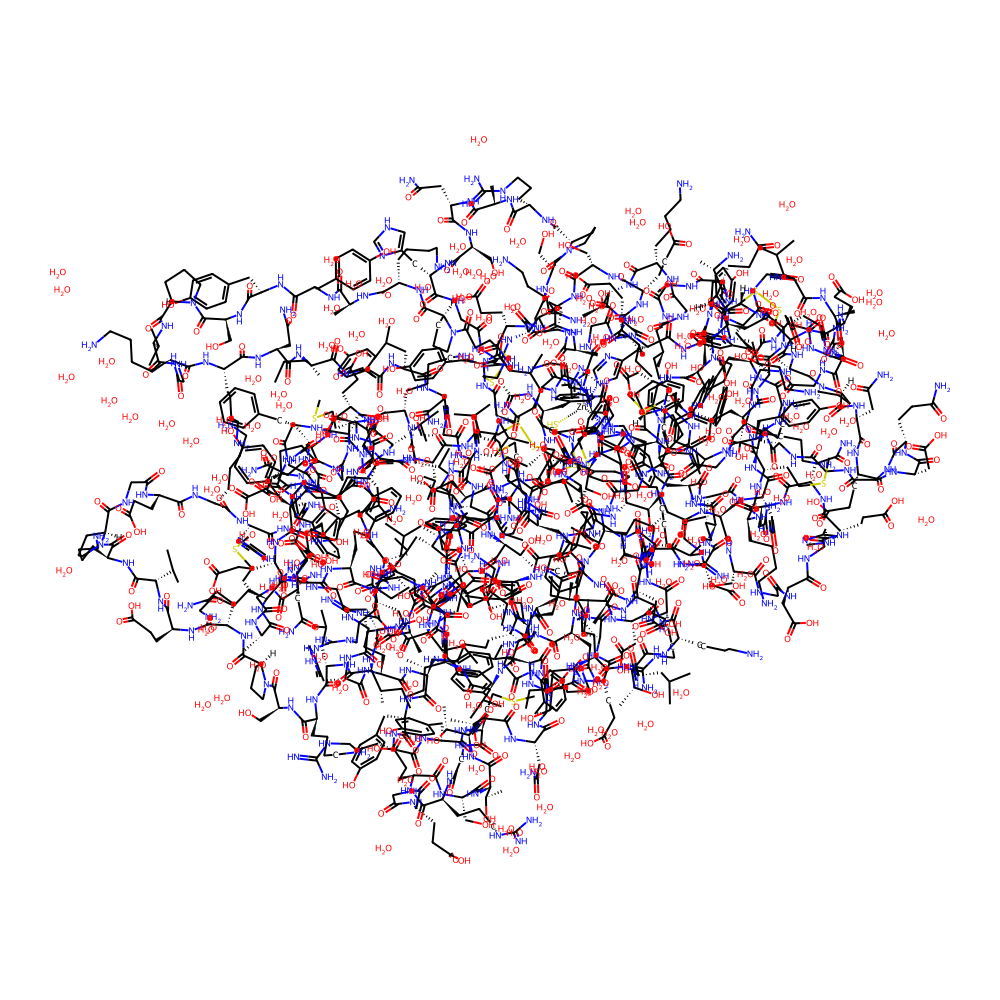

In [5]:
from rdkit.Chem.SaltRemover import SaltRemover

receptor = Chem.MolFromPDBFile("./data/receptors/2oi0.pdb", sanitize=True, removeHs=True)
rdkit.Chem.Draw.MolToImage(
    receptor, size=(1000, 1000), kekulize=True, wedgeBonds=True, fitImage=True
)
#receptor = remove_solvent(receptor)
Chem.GetSymmSSSR(receptor)

receptor.GetRingInfo().NumRings()

rdkit.Chem.Draw.MolToImage(
    receptor, size=(1000, 1000), kekulize=True, wedgeBonds=True, fitImage=True
)

In [6]:
ligand = Chem.SDMolSupplier("./data/ligands/283_model.sdf", sanitize=True, removeHs=False)[0]
ligand = Chem.AddHs(ligand)
ligand.UpdatePropertyCache()
Chem.GetSymmSSSR(ligand)
ligand.GetRingInfo().NumRings()
rdkit.Chem.Draw.MolToImage(ligand, size=(1000, 1000), kekulize=False, wedgeBonds=True, fitImage=True)

from pmapper.pharmacophore import Pharmacophore as P
from rdkit import Chem
from rdkit.Chem import AllChem
from pprint import pprint

p = P()
p.load_from_mol(receptor)

print(p.get_feature_ids())
print(p.get_feature_coords())
print(p.get_features_count())
print(p.save_to_pma("./receptor.pma"))


{'a': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36), 'D': (37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 2

**Now, we generate the pharmacophoric points for the two moleculesm and display them.**

{(AR0, AR0): 0.0, (AR0, D0): 5.3, (A0, AR0): 3.8, (A1, AR0): 3.9, (A2, AR0): 2.8, (AR0, H0): 4.2, (AR0, H1): 5.4, (D0, D0): 0.0, (A0, D0): 6.3, (A1, D0): 4.7, (A2, D0): 6.8, (D0, H0): 8.9, (D0, H1): 10.5, (A0, A0): 0.0, (A0, A1): 2.5, (A0, A2): 6.5, (A0, H0): 7.4, (A0, H1): 7.9, (A1, A1): 0.0, (A1, A2): 6.6, (A1, H0): 8.0, (A1, H1): 8.7, (A2, A2): 0.0, (A2, H0): 2.3, (A2, H1): 4.1, (H0, H0): 0.0, (H0, H1): 2.1, (H1, H1): 0.0}
1129
7
D0 a173 3.4 [41.158, 31.976, 4.586] [41.328, 28.814, 5.841]
D0 a311 3.1 [41.158, 31.976, 4.586] [40.376, 30.351, 7.067]
D0 a373 3.5 [41.158, 31.976, 4.586] [38.743, 29.611, 3.568]
A1 d237 2.9 [41.153, 28.787, 1.199] [39.936, 26.231, 0.716]
A1 d284 3.3 [41.153, 28.787, 1.199] [39.436, 26.959, 3.356]
H1 h93 3.7 [48.4985, 24.634, 3.3645] [47.52, 25.066, -0.193]
6
7
{a373, a311, a173, d284, h93, d237}
[AR0, D0, A0, A1, A2, H0, H1]


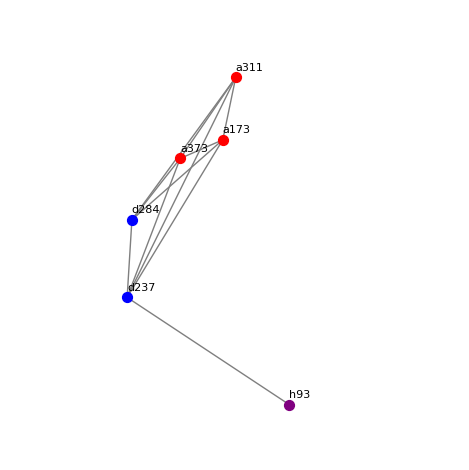

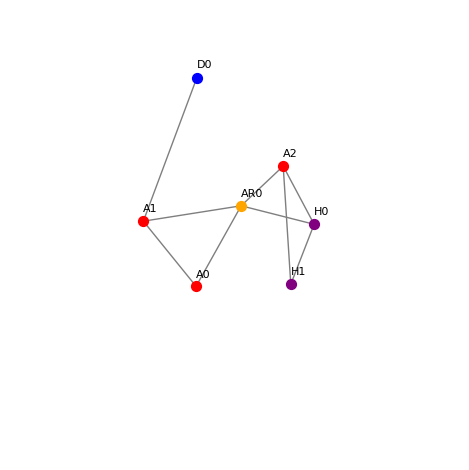

In [7]:
# R_features = get_features(receptor, "receptor")
# L_features = get_features(ligand, "ligand")

from src.graph.interaction_graph import filter_receptor_features_close_to_ligand
from src.mol_processing.features import load_features_from_pma_file, spatial_selection


L_features = load_features_from_pma_file("./data/pharmacophores/TACE-AS/ligand.pma", reversed=False)
R_features = load_features_from_pma_file("./data/pharmacophores/TACE-AS/receptor.pma", reversed=False)


name_features_by_count(R_features, is_ligand=False)
name_features_by_count(L_features, is_ligand=True)

window = ((39.327, 49.520), (23.319, 32.989), (-0.494, 5.721))

# L_features = spatial_selection(L_features, window)
# R_features = spatial_selection(R_features, window)

R_distance_matrix = build_distance_matrix(R_features)
L_distance_matrix = build_distance_matrix(L_features)

print(L_distance_matrix)
print(len(R_features))
print(len(L_features))


_, R_features = filter_receptor_features_close_to_ligand(L_features, R_features)

print(len(R_features))
print(len(L_features))
print(R_features)
print(L_features)


R_distance_matrix = build_distance_matrix(list(R_features))
L_distance_matrix = build_distance_matrix(list(L_features))


draw_feature_list(R_features, R_distance_matrix)
draw_feature_list(L_features, L_distance_matrix)

**As those molecules are way too big for our purposes, we will subselect a spatial region, which corresponds to the supposed docking region. This is a trick used in classical experiments as well.**

**As you see, our final graphs are very simpple. In reality they should be a bit bigger, but here we want a small graph for a clear example.**

**Below, you can see the binding interaction graph. It represents all the possible configurations, a node here being a node of the ligand and one of the receptor interacting, If Two nodes are linked, that means that both positions are possible together.**

0.0 3.9 InteractionNode(L_feature=AR0, R_feature=a373, weight=0.077) InteractionNode(L_feature=AR0, R_feature=a311, weight=0.077)
True 5
0.0 3.5 InteractionNode(L_feature=AR0, R_feature=a373, weight=0.077) InteractionNode(L_feature=AR0, R_feature=a173, weight=0.077)
True 5
0.0 2.7 InteractionNode(L_feature=AR0, R_feature=a373, weight=0.077) InteractionNode(L_feature=AR0, R_feature=d284, weight=0.1091)
True 5
0.0 10.6 InteractionNode(L_feature=AR0, R_feature=a373, weight=0.077) InteractionNode(L_feature=AR0, R_feature=h93, weight=0.0795)
False 5
0.0 4.6 InteractionNode(L_feature=AR0, R_feature=a373, weight=0.077) InteractionNode(L_feature=AR0, R_feature=d237, weight=0.1091)
True 5
5.3 0.0 InteractionNode(L_feature=AR0, R_feature=a373, weight=0.077) InteractionNode(L_feature=D0, R_feature=a373, weight=0.6686)
False 5
5.3 3.9 InteractionNode(L_feature=AR0, R_feature=a373, weight=0.077) InteractionNode(L_feature=D0, R_feature=a311, weight=0.6686)
True 5
5.3 3.5 InteractionNode(L_feature=AR

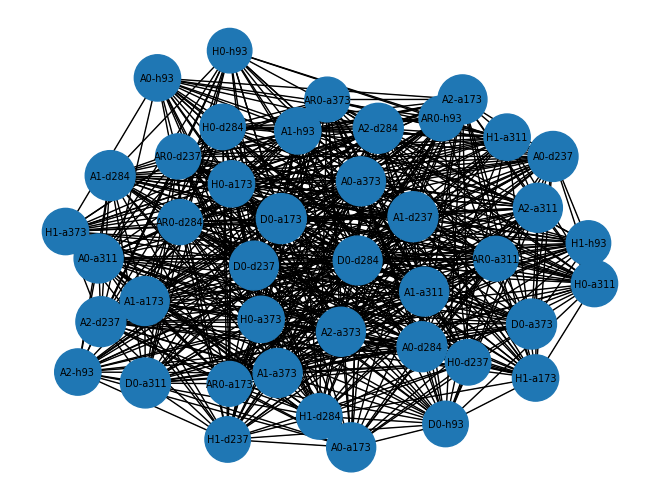

Graph with 42 nodes and 597 edges


In [8]:
import networkx as nx
from graph.interaction_graph import build_weighted_binding_interaction_graph

interaction_graph = build_weighted_binding_interaction_graph(
    L_features, R_features, L_distance_matrix, R_distance_matrix
)

# interaction_graph = build_binding_interaction_graph(L_distance_matrix, R_distance_matrix)
draw_interaction_graph(interaction_graph)

print(interaction_graph)
interaction_graph

In [17]:
from src.solver.classical import find_max_clique

max_clique = find_max_clique(interaction_graph)
print(max_clique)
print(len(max_clique))
print([s for s in max_clique if s.startswith("H2")])

['AR0-a173', 'H1-d284', 'A2-a373', 'H0-a373', 'A2-d284', 'H1-d237', 'H0-d284', 'H0-d237', 'A0-a173', 'A2-d237', 'AR0-a373', 'A1-a311', 'A0-a311', 'AR0-a311']
14
[]


**To translate the Max Clique problem to a MIS problem, we wimply have to take the complementary of the binding graph. Here we obtain the graph below:**

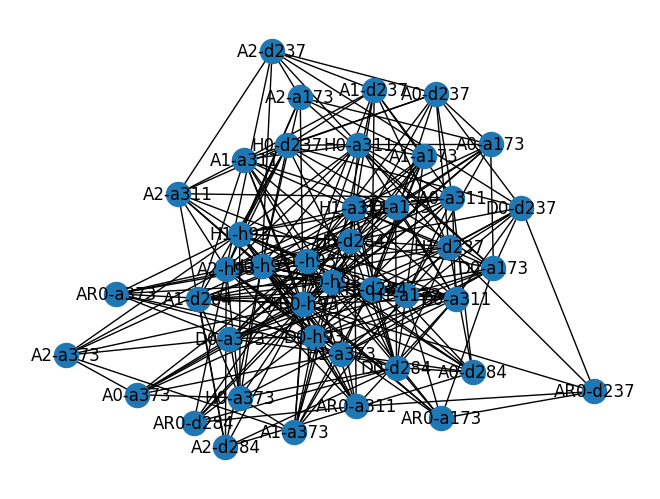

In [10]:
compl = build_complementary_graph(interaction_graph)
pos = nx.spring_layout(compl)

nx.draw(
    compl,
    pos=pos,
    with_labels=True,
    node_color="tab:blue",
)

nx.write_adjlist(compl, "small.adjlist")

**Here we obtain a non local graph, as we always do when creating the complementary of an interaction graph. This is a problem, because it will make the mapping to a UDG more difficult. Below you can see that the mapped UDG is lacking a connection between H30-d8 and H28-d8.**

Problem while generating UDG graph: the number of resulting edges is not equal to the inital number of  edges.


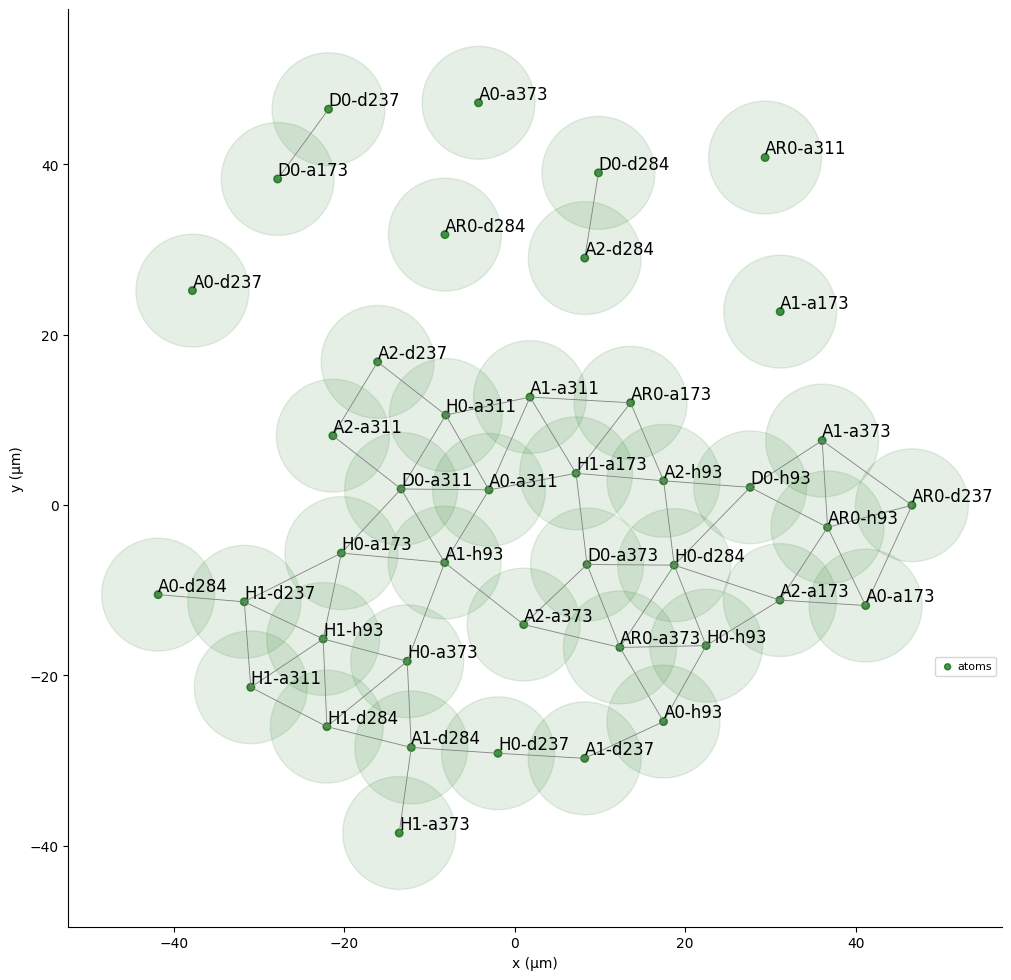

In [11]:
register = embed_problem_to_QPU(interaction_graph)

register.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0), draw_graph=True, draw_half_radius=True
)

**To solve this, we have to add ancillary nodes between the two, to act as a quantum link. This will effectively entangle them.**

**Note that we are using the function demo_positions here instead of map_to_udg, because of the lack of time we coul not get the function to work properly with quantum links added.**

We then obtain the updated registry below.

In [12]:
from graph.mapping import embed_to_register, add_quantum_link, demo_positions


add_quantum_link(compl, "H30-d6", "H30-d8", 1)

pos = demo_positions(pos)

reg = embed_to_register(pos)

reg.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0), draw_graph=True, draw_half_radius=True
)

NetworkXError: The edge H30-d6-H30-d8 is not in the graph

**This is the graph corresponding to the newly linked graph, effectively removing its non locality.**

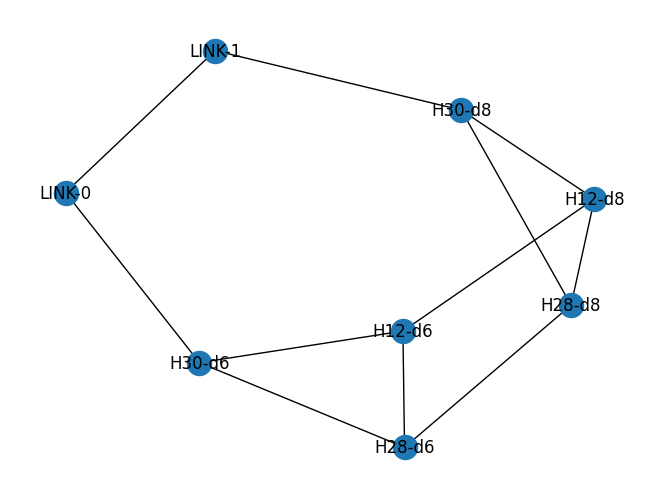

In [ ]:
nx.draw(
    compl,
    with_labels=True,
    node_color="tab:blue",
)

**Now the register is ready, we can start solving the problem ! We call the VQAA solver on this graph, with a set of parameters ranges to optimize. We specify here the number of confomations we want as output with number_best_solutions.**

In [ ]:
counts_solution, opt_param, solution = solver_VQAA(
    reg,
    compl,
    penalty_term=20,
    number_best_solutions=14,
    omega_range=(0.5, 10),
    detuning_range=(2, 5),
    time_range=(10, 24),
    repetitions=10,
    simple_sequence=True,
    complex_sequence=False,
)

/Users/mathieu.garrigues/Projects/perso/Quantum-Docking/./src/solver/quantum.py:75: DeprecationWarning: The 'Chadoq2' device has been deprecated. For a similar device combining global and local addressing, consider using `DigitalAnalogDevice`.
  sequence = Sequence(register, device)
/Users/mathieu.garrigues/Projects/perso/Quantum-Docking/./src/solver/quantum.py:75: DeprecationWarning: The 'Chadoq2' device has been deprecated. For a similar device combining global and local addressing, consider using `DigitalAnalogDevice`.
  sequence = Sequence(register, device)
/Users/mathieu.garrigues/Projects/perso/Quantum-Docking/./src/solver/quantum.py:75: DeprecationWarning: The 'Chadoq2' device has been deprecated. For a similar device combining global and local addressing, consider using `DigitalAnalogDevice`.
  sequence = Sequence(register, device)
/Users/mathieu.garrigues/Projects/perso/Quantum-Docking/./src/solver/quantum.py:75: DeprecationWarning: The 'Chadoq2' device has been deprecated. Fo

In [ ]:
opt_param

array([1.19357201e+04, 7.53497872e+00, 2.25942763e+00])

**Here we plot the final distribution of all the possible states. The highest ones should be good candidates for Max clique.**

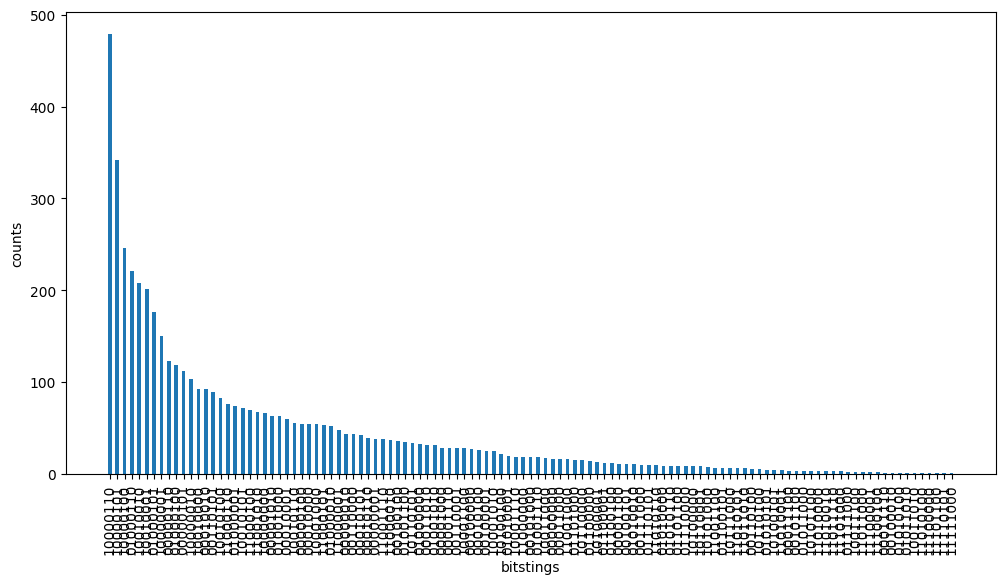

In [ ]:
plot_distribution(counts_solution)

In [ ]:
I = approx.maximum_independent_set(compl)
print(f"Maximum independent set of G: {I}")

Maximum independent set of G: {'LINK-0', 'H30-d8', 'H12-d6'}


In [ ]:
solution

[['D0-d0', 'D1-d0', 'LINK-0'],
 ['D0-d0', 'D1-d0', 'LINK-1'],
 ['D0-d0', 'D1-d0'],
 ['D0-a0', 'D1-d0', 'LINK-0'],
 ['D0-d0', 'D1-a0', 'LINK-0'],
 ['D0-d0', 'D1-a0', 'LINK-1'],
 ['D0-a0', 'D1-d0', 'LINK-1'],
 ['D0-d0', 'LINK-1'],
 ['D1-d0', 'LINK-0'],
 ['D0-a0', 'D1-d0'],
 ['D1-d0', 'LINK-1'],
 ['D0-d0', 'LINK-0'],
 ['D0-d0', 'D1-a0'],
 ['D1-a0', 'LINK-0']]

In [ ]:
def remove_ancilary_nodes(cliques: list[str]) -> list[str]:
    return [[node for node in clique if "LINK" not in node] for clique in cliques]


cliques = remove_ancilary_nodes(solution)

**We remove the ancillary links from the obtained lists, and plot the initial binding interaction graph with the cliques.**

In [ ]:
draw_multiple_cliques(interaction_graph, cliques)

NameError: name 'cliques' is not defined

**We now have akk the information we need to know the docking poses, and we plot them below:**

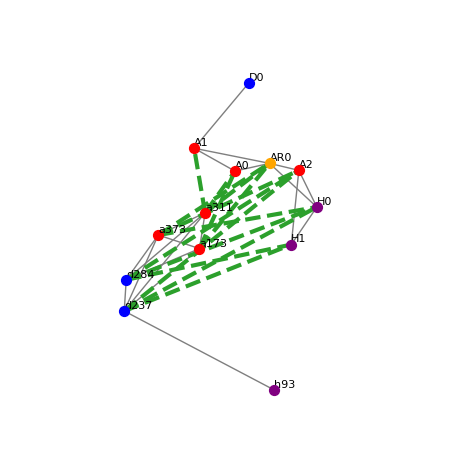

In [18]:
draw_multiple_dockings(
    L_features, L_distance_matrix, R_features, R_distance_matrix, cliques_list=[max_clique]
)